In [1]:
import numpy as np
import pandas as pd
import os
import glob as gb
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

C:\Users\HMILAB\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_PATH ='../data/image/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_train[n] = img 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 36.98it/s]


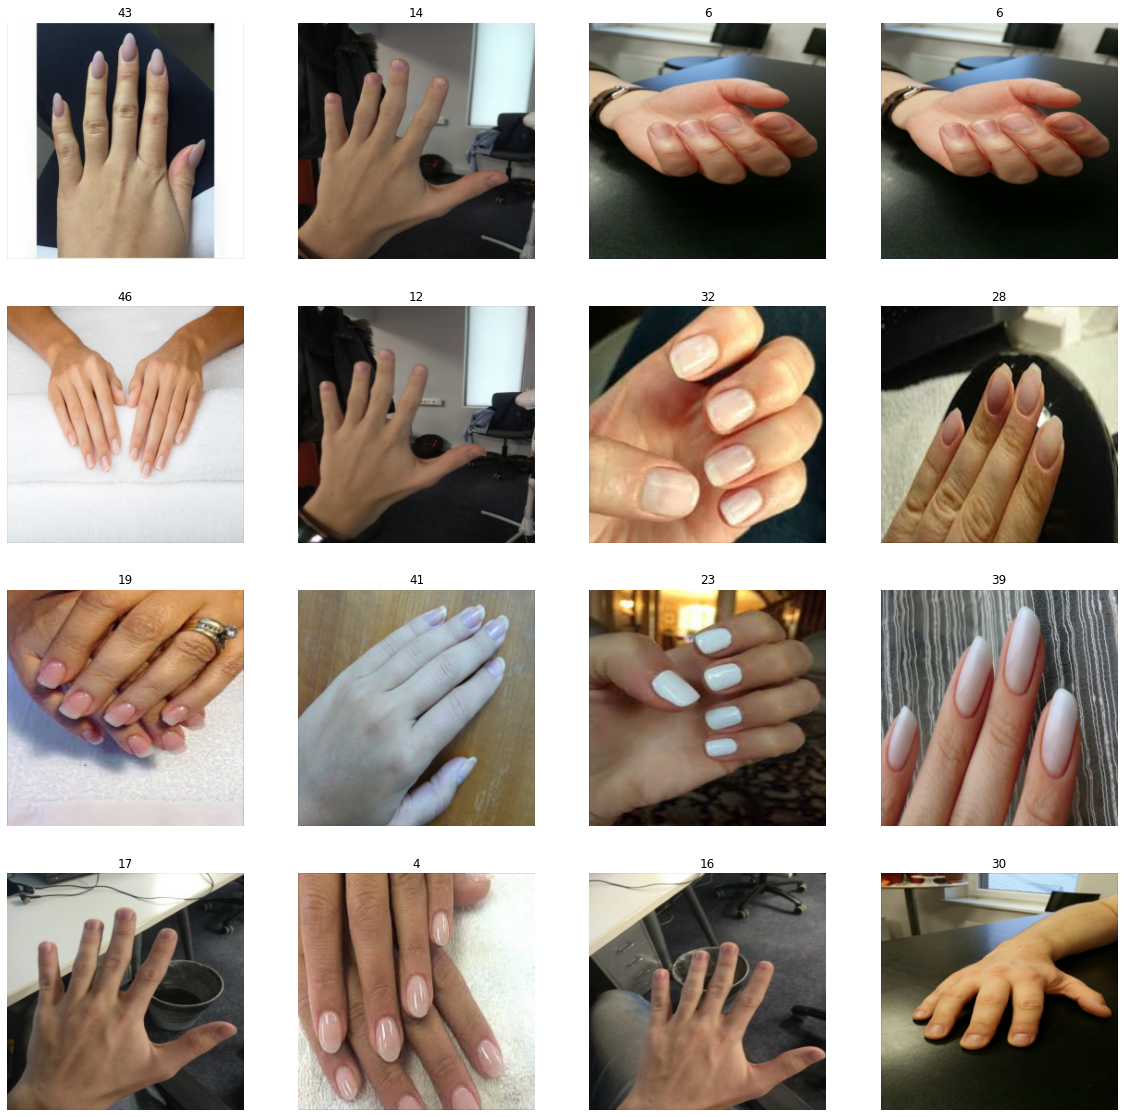

In [3]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(i)

In [4]:
TRAIN_PATH ='../data/mask/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    mask = imread(id_)[:,:,:1] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = mask 

C:\Users\HMILAB\AppData\Local\Temp/ipykernel_1628/21886425.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 100.42it/s]


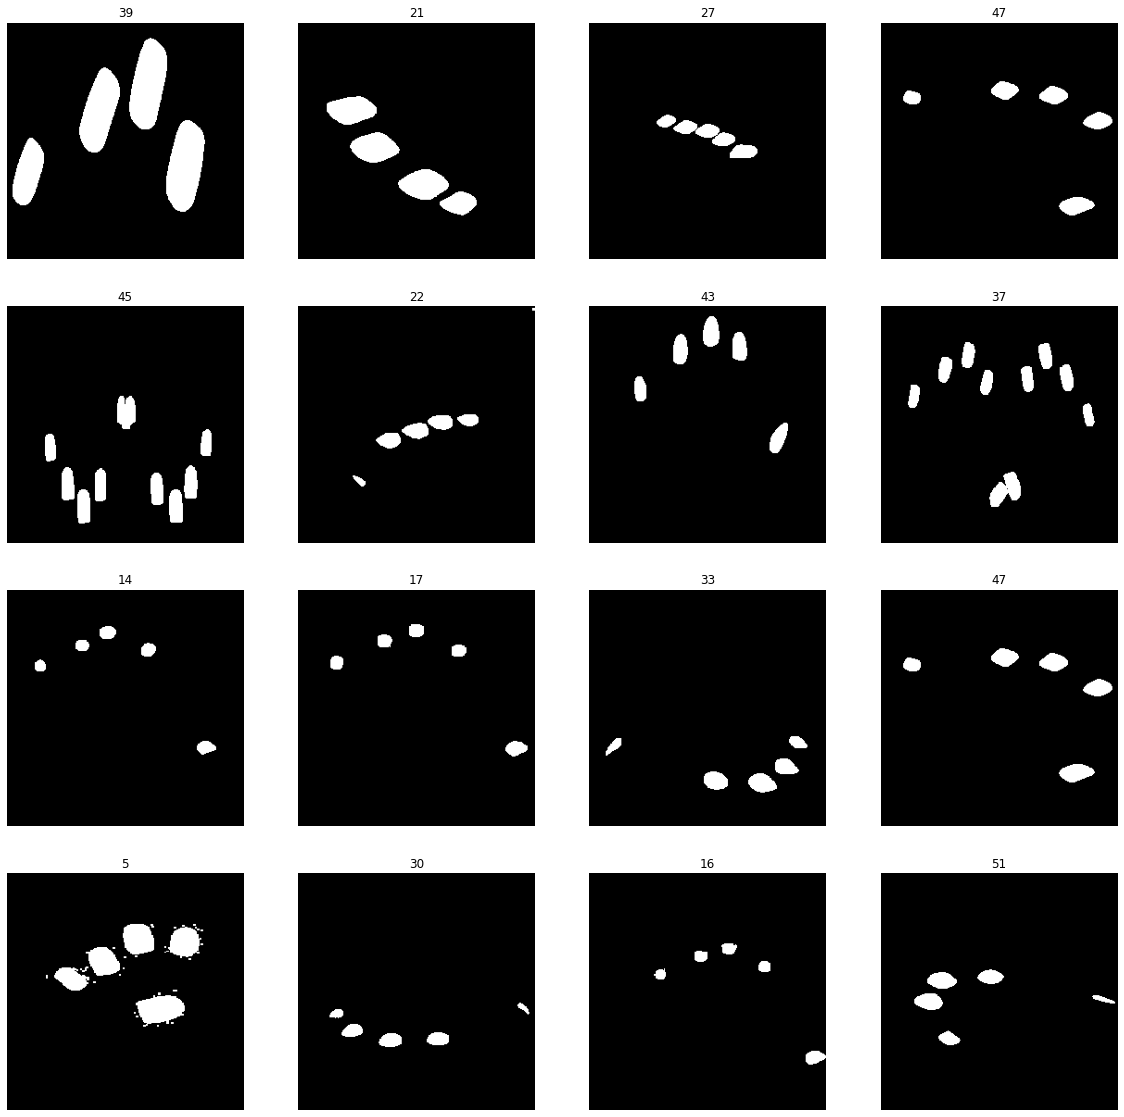

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
import keras.backend as K
import torch
import tensorflow.keras as keras
from tensorflow.keras import layers

In [7]:
def DiceLoss(targets, inputs, smooth=1e-6):
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum((targets*inputs))
#     print(targets*inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [10]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Contraction path
    
#     inputs = data_augmentation(inputs)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    
    #Expansive path 
    
     
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = DiceLoss, metrics = ['accuracy'])

#     model.summary()
    
    return model

In [12]:
pip install cudatoolkit

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit


In [11]:
model=unet(256,256,3)

InternalError: cudaGetDevice() failed. Status: cudaGetErrorString symbol not found.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
# callback=[EarlyStop , Reduce_LR,model_check]
callback=[Reduce_LR,model_check]



In [ ]:
X_train = X_train.astype(float)
Y_train = Y_train.astype(float)
print(type(X_train))

In [323]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=8,steps_per_epoch=len(X_train)//8,epochs=50,
                 callbacks=callback,verbose=1,shuffle=True)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.8934 - accuracy: 0.1802
Epoch 1: val_loss improved from inf to 0.88254, saving model to model.hdf5
6/6 [==============================] - 22s 4s/step - loss: 0.8934 - accuracy: 0.1802 - val_loss: 0.8825 - val_accuracy: 0.1067 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.8913 - accuracy: 0.2264
Epoch 2: val_loss did not improve from 0.88254
6/6 [==============================] - 22s 4s/step - loss: 0.8913 - accuracy: 0.2264 - val_loss: 0.8831 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.8887 - accuracy: 0.1905
Epoch 3: val_loss improved from 0.88254 to 0.86846, saving model to model.hdf5
6/6 [==============================] - 22s 4s/step - loss: 0.8887 - accuracy: 0.1905 - val_loss: 0.8685 - val_accuracy: 0.3096 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.2164
Epoch 4: va

Epoch 29/50
6/6 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.9374
Epoch 29: val_loss did not improve from 0.48618
6/6 [==============================] - 22s 4s/step - loss: 0.6517 - accuracy: 0.9374 - val_loss: 0.6001 - val_accuracy: 0.8724 - lr: 5.0000e-04
Epoch 30/50
6/6 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.8409
Epoch 30: val_loss did not improve from 0.48618
6/6 [==============================] - 23s 4s/step - loss: 0.6886 - accuracy: 0.8409 - val_loss: 0.5998 - val_accuracy: 0.8778 - lr: 5.0000e-04
Epoch 31/50
6/6 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.9272
Epoch 31: val_loss did not improve from 0.48618
6/6 [==============================] - 23s 4s/step - loss: 0.6484 - accuracy: 0.9272 - val_loss: 0.5465 - val_accuracy: 0.9361 - lr: 5.0000e-04
Epoch 32/50
6/6 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.8625
Epoch 32: val_loss did not improve from 0.48618
6/6 

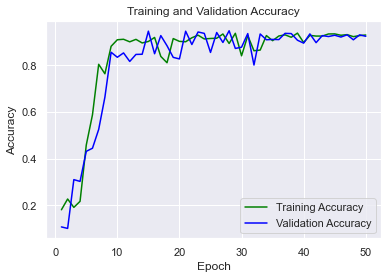

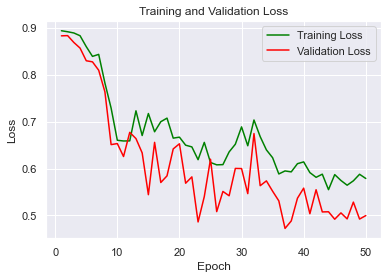

In [324]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [361]:
model.load_weights("model.hdf5")

In [408]:
type(X_train)

numpy.ndarray

In [362]:
y_pred=model.predict(X_train)

2/2 [==============================] - 4s 2s/step


In [404]:
y_pred_1=(y_pred > 0.3).astype(np.uint8)

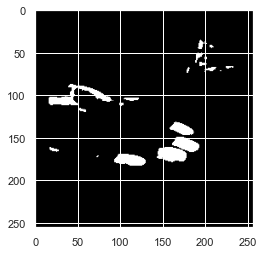

In [405]:
from random import randrange
index = randrange(len(X_train))
plt.imshow(y_pred_1[index],cmap='gray')
plt.show()

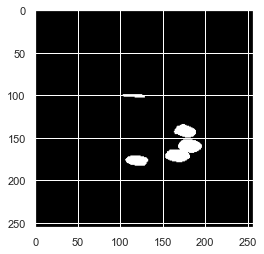

In [406]:
plt.imshow(Y_train[index],cmap='gray')
plt.show()